# Cognitive Helpdesk

- ### Problem Statement: 
    -   Business neeeds to use AI to answer customers requests automatically based on request text, and drirect to agent when needed. 
    - Develop a ML model that detects the intent of the customer from the web requests. Down stream application use this intent to answer the request or direct call to specialized agent.
- ### Outcome: 
    -  This model able to identify top 70% problems and recommend users the answers.  

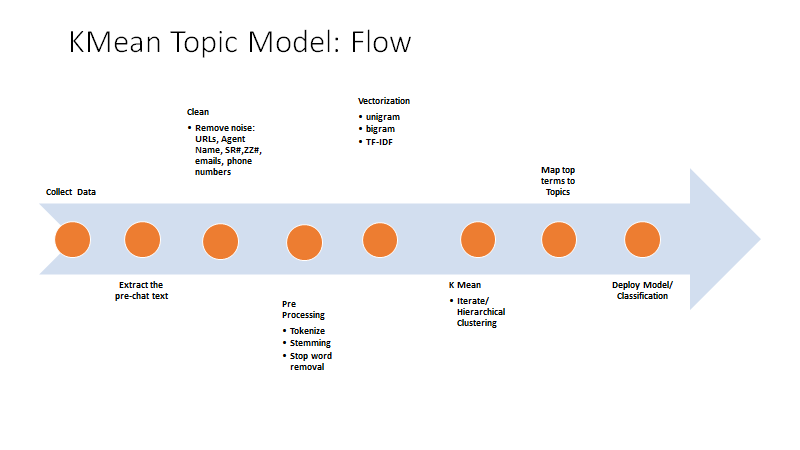

# Things Considerted

- Cluster size, try with small as 5 ; Once the code and working the change to 10,20, 50, 100
- Use Word cloud to visualize the word distribution by cluster, this will  help to determine which clusters to worth to look at it manually.
- Pickle(save) the model. Important to get the same results when presenting results. 
- Text summarization API from genism package will help to identify the themes which helps business to understand cluster topics better
- Cluster specific Bigrams/Trigrams will useful for auto labeling clusters
- Considered LDA and Word2Vec models; I used Kmean because it produced good results with our chat data.  LDA + Word23Vec models generally produce good results on data such as News, Contract Document
- pyLDAvis  package to visualize topic terms.
- D3.js to visualize when comparing models
- Separate model developed to test the accuracy/quality for the clustering.
- Cluster Labeling done by separate model using top terms in the cluster.

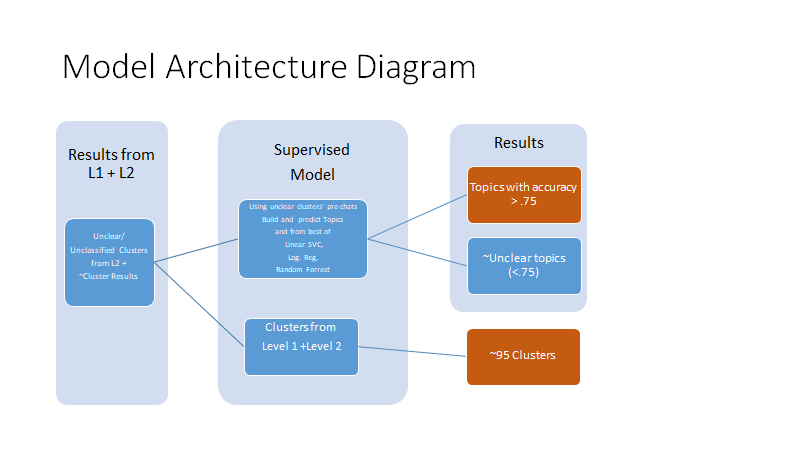

In [2]:
import sys
import csv
import string
import re

import pandas as pd
import numpy as np
import pickle

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.collocations import *
from collections import Counter
from nltk.corpus import stopwords

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer


import matplotlib
from pprint import pprint

In [3]:
print("Filenames created")
if sys.platform == "win32" :
    inputfilepath = 'C:\\01 Projects\\CAO\\data\\original\\'
    outputfilepath = 'C:\\01 Projects\\CAO\\data\\output\\'
    
    inputfile = 'LNotes_just_prechat.csv'
    outputfile = 'LN_Cluster_Level2_Kmean_Mar15_1.csv'
    inputfilepath = inputfilepath + inputfile
    outputfilepath = outputfilepath + outputfile

else:
    
    inputfilepath = '//Users//ralagesan//Documents//PycharmProjects//SupportCAO//data//'
    outputfilepath = '//Users//ralagesan//Documents//PycharmProjects//SupportCAO//data//output//'
    
    modelfilepath = '/Users/ralagesan/Documents/PycharmProjects/SupportCAO/data/output/model/'
    inputfile = 'prechat_few.csv'
    #inputfile = 'PreChat_Full_1.csv'
    inputfile = 'L2_LNotes_just_prechat.csv'

    outputfile = 'prechat_few_Kmean_2.csv'
    inputfilepath = inputfilepath + inputfile
    outputfilepath = outputfilepath + outputfile
    

Filenames created


# Tokenize, remove stopwords

In [4]:
def preprocess_regex(text):
    #remove URLs
    regex = "(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
    lowers = re.sub(regex, ' ', text)
    regex = "\w+ \w+(/\w+){0,1}/\w+/IBM@IBMIE"
    lowers = re.sub(regex, ' ', text)
    regex =" - (.\w+){1,3}/\w+/IBM:"
    lowers = re.sub(regex, ' ', text)
    regex = "(\w+ ){1,2}- (WWSED_)\w+"
    lowers = re.sub(regex, ' ', text)
    #remove Emails in chat agent
    regex = "\w+@[a-z]{2,3}.ibm.com - \w+ \w+/\w+/IBM:"
    lowers = re.sub(regex, ' ', lowers)
    #remove chat agent specific text
    regex = "\w+ \w+ - (WWSED_)\w+"
    lowers = re.sub(regex, ' ', lowers)

    #remove regular Email
    regex = "[\w\.-]+@[\w\.-]+"
    lowers = re.sub(regex, ' ', lowers)
    #remove part/ticket nbrs
    regex = "(SR|ZZ|IN)\w+"
    lowers = re.sub(regex, ' ', lowers)    
    #remove Emails in chat agent
    regex = "\w+@[a-z]{2,3}.ibm.com - \w+ \w+/\w+/IBM:"
    lowers = re.sub(regex, ' ', lowers)
    lowers = lowers.lower()
    #remove Emails in chat agent
    regex = "\w+@[a-z]{2,3}.ibm.com - \w+ \w+/\w+/ibm:"
    lowers = re.sub(regex, ' ', lowers)
    regex = "\w+  wwsedhden"
    lowers = re.sub(regex, ' ', lowers)
    #remove the punctuation using the character deletion step of translate
    regex = "\w+\(\d{1,2}:\d{2}:\d{2}\):"
    lowers = re.sub(regex, ' ', lowers)
    regex = re.compile('[^a-zA-Z ]')
    #First parameter is the replacement, second parameter is your input string
    lowers = regex.sub(' ', lowers)

    #print(lowers)
    return lowers

In [5]:
stop_words = nltk.corpus.stopwords.words('english') 

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

def preprocess(text):
    text = text.lower()
    doc = nltk.word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    #doc = stem_tokens(doc,stemmer)
    return doc

In [6]:
prechat_list=[]
prechat_token_dict={}
rowid = 0
with open(inputfilepath, encoding ='latin') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        clean_chatstr = preprocess_regex(row[0])
        prechat_list.append(clean_chatstr)
        prechat_token_dict[rowid] = clean_chatstr.lower().translate(string.punctuation)
        rowid = rowid +1  

In [7]:
stopwords = nltk.corpus.stopwords.words('english') 
stopwords = stopwords +['thank','thanks','ye','hello','hi','im','hii','ticket','serial','ok','lotus','lotu','pleas','wwsedhden','zzvb','contractor',
                        'would','want','like','support','regard',
                        'saumya','team','zzzn','zzz','zzl','ha','get','thi','notes','note','ibm',
                        'may','chat','help','having','have','need','wwsed','hden']


In [8]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stopwords,ngram_range=(1,2))
vec=tfidf.fit(prechat_token_dict.values()) 
vectorized_prechat = vec.transform(prechat_token_dict.values())

filename = 'TfIdf_Vec_L2_Apr29_0.sav'
pickle.dump(vec, open(filename, 'wb'))

In [9]:
filename = 'Vectorized_Prechat_L2_Apr29_0.sav'
pickle.dump(vectorized_prechat, open(filename, 'wb'))

In [10]:
vec_loaded = pickle.load(open('TfIdf_Vec_L2_Apr29_0.sav', 'rb'))
vec_tranform_loaded = pickle.load(open('Vectorized_Prechat_L2_Apr29_0.sav', 'rb'))

str1 = 'I forgot lotus notes password.'
response = vec_loaded.transform([str1])
print(response)

  (0, 33833)	0.303550493862839
  (0, 17738)	0.7114456279339388
  (0, 17715)	0.6337998234216463


# 50 Cluster Analysis

In [11]:
true_k= 50
km_model_50 = KMeans(n_clusters=true_k,init='k-means++', max_iter=100)
km_model_50.fit(vec_tranform_loaded)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
filename = 'Sklearn_'+str(true_k)+'_KMean_Mdl_L2_Apr29_0.sav'
pickle.dump(km_model_50, open(filename, 'wb'))
#/Users/ralagesan/Documents/PycharmProjects/SupportCAO/output

In [13]:
print(vec_loaded.get_feature_names())

['aagrwal', 'aaraa', 'aaraa norway', 'ab', 'ab sastri', 'aba', 'aba etc', 'ababa', 'ababa follow', 'abdul', 'abend', 'abend password', 'abgefragt', 'abhishek', 'abhishek kteam', 'abhyankar', 'abhyankar emp', 'abil', 'abil check', 'abil look', 'abil open', 'abil replic', 'abil use', 'abil work', 'abl', 'abl abl', 'abl acc', 'abl access', 'abl aceess', 'abl add', 'abl ani', 'abl anyth', 'abl appli', 'abl approv', 'abl archiv', 'abl assess', 'abl assist', 'abl avail', 'abl back', 'abl book', 'abl bring', 'abl brows', 'abl chang', 'abl changereset', 'abl check', 'abl close', 'abl complet', 'abl conduct', 'abl configur', 'abl confur', 'abl connect', 'abl connectit', 'abl contact', 'abl continu', 'abl copi', 'abl creat', 'abl databas', 'abl delet', 'abl desktop', 'abl domino', 'abl download', 'abl drag', 'abl edit', 'abl email', 'abl enter', 'abl even', 'abl figur', 'abl find', 'abl finish', 'abl fix', 'abl gener', 'abl give', 'abl go', 'abl import', 'abl instal', 'abl ive', 'abl lanch', 'ab

In [14]:
print("Top terms per cluster:")
order_centroids = km_model_50.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
#print(terms)
wordlist = "Word "
for i in range(1,5):
    wordlist = wordlist +",Word "+str(i)
print(wordlist)
for i in range(true_k):
    singledoc = "Cluster %d:" % i    
    for ind in order_centroids[i, :5]:
        #print(' %s' % terms[ind])
        singledoc = singledoc + "," +  terms[ind]

    print(singledoc)

Top terms per cluster:
Word ,Word 1,Word 2,Word 3,Word 4
Cluster 0:,address given,renew email,wwnab,send certif,modifi doe
Cluster 1:,configur,full increas,full reset,full privileg,full possibl
Cluster 2:,time number,reboot first,ac,ac reboot,number week
Cluster 3:,password issu,issu,password,face password,issu cant
Cluster 4:,password,reset,reset password,password reset,temporari
Cluster 5:,idea instal,alon win,win file,perl idea,perl
Cluster 6:,crash,keep crash,keep,open,crash start
Cluster 7:,id insid,chang forward,insid chang,rather email,manag function
Cluster 8:,logon mail,mail order,order temporari,howev cant,cant logon
Cluster 9:,setup applic,applic new,new temp,password doesnt,tri setup
Cluster 10:,abl login,login,abl,login password,password
Cluster 11:,tri et,sent document,et access,link tri,document link
Cluster 12:,directori doe,cross certif,domino directori,doe contain,cross
Cluster 13:,add databas,add,databas,unabl add,workspac abl
Cluster 14:,password,new password,vers g

In [15]:
unique, counts = np.unique(km_model_50.labels_, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0     1]
 [    1    27]
 [    2     1]
 [    3    37]
 [    4  1858]
 [    5     2]
 [    6   105]
 [    7     1]
 [    8     1]
 [    9     1]
 [   10   118]
 [   11     1]
 [   12    13]
 [   13     7]
 [   14     1]
 [   15     1]
 [   16     1]
 [   17     1]
 [   18    29]
 [   19   461]
 [   20    23]
 [   21     1]
 [   22    33]
 [   23   442]
 [   24     1]
 [   25     1]
 [   26   146]
 [   27 10351]
 [   28   116]
 [   29    11]
 [   30    16]
 [   31    53]
 [   32    23]
 [   33     2]
 [   34    36]
 [   35    25]
 [   36    74]
 [   37     2]
 [   38   145]
 [   39    12]
 [   40    25]
 [   41     5]
 [   42    17]
 [   43   345]
 [   44     8]
 [   45   120]
 [   46    99]
 [   47    21]
 [   48    63]
 [   49    22]]


In [22]:
unique, counts = np.unique(km_model_50.labels_, return_counts=True)
#print (np.asarray((unique, counts)).T)
new_label_50 = np.asarray(unique)

In [23]:
pd_docs = pd.DataFrame(prechat_list,columns =["prechat"])
pd_results = pd.DataFrame(km_model_50.labels_,columns=['Cluster#'])

In [28]:
ldf_Kmean_Lbl1 = pd.concat([pd_results, pd_docs], axis=1)
ldf_Kmean_Lbl1.to_csv("skLean_kmean_"+str(true_k)+"L2_cluster_apr29_0.csv", sep=',', encoding='utf-8')

In [29]:
from pandas import ExcelWriter
outputFilename = "skLean_kmean_"+str(true_k)+"L2_cluster_apr29_0_split_.xlsx"
input = pd.read_csv("skLean_kmean_"+str(true_k)+"L2_cluster_apr29_0.csv",encoding='latin',error_bad_lines = False)
clust = input["Cluster#"].unique()
clust.sort(axis=0)

In [30]:
writer = pd.ExcelWriter(outputFilename)
for num in clust:
    data = input[input["Cluster#"]==num][['Cluster#','prechat']]
    data.to_excel(writer,'Cluster%s'%(num),encoding='utf8')
writer.save()

# Lotus  Notes Model Implementation

## K Mean Model Highlights
- ### No dictionary
- ### Stop words derived from model iterations
- ### Based on Unigrams and Bigrams
- ### Topics cluster labels are named after eyeball the cluster data
- ### Hierarchical (Two level) clustering (Big/Multitopic clusters are classified again)3
- ### Supervised model used for unclassified by Kmean model to get better accuracy


### Predict Cluster assignment

In [6]:
topicdef_dict = {}
topicdeffile="100TopicDefn_Apr29.csv"
with open(topicdeffile, encoding ='utf-8') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        topicdef_dict[row[0]] = row[1]

In [7]:
vec_loaded = pickle.load(open('TfIdf_Vec_Apr28_1.sav', 'rb'))
vec_tranform_loaded = pickle.load(open('Vectorized_Prechat_Apr28_1.sav', 'rb'))

L2_vec_loaded = pickle.load(open('TfIdf_Vec_L2_Apr29_0.sav', 'rb'))
L2_vec_tranform_loaded = pickle.load(open('Vectorized_Prechat_L2_Apr29_0.sav', 'rb'))

LN_model = pickle.load(open('Sklearn_50_KMean_Mdl_Apr28_1.sav', 'rb'))
L2_LN_model = pickle.load(open('Sklearn_50_KMean_Mdl_L2_Apr29_0.sav', 'rb'))

In [8]:
print(topicdef_dict["5"])

LN - Unable to open


In [9]:
inputfile1 = 'LNotes_just_prechat.csv'
inputdatapath = '//Users//ralagesan//Documents//PycharmProjects//SupportCAO//data//'
inputfilepath1 = inputdatapath + inputfile1
print(inputfilepath1)

//Users//ralagesan//Documents//PycharmProjects//SupportCAO//data//LNotes_just_prechat.csv


In [10]:
prechat_list=[]
prechat_token_dict={}
rowid = 0
with open(inputfilepath1, encoding ='latin') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        clean_chatstr = preprocess_regex(row[0])
        prechat_list.append(clean_chatstr)
        prechat_token_dict[rowid] = clean_chatstr.lower().translate(string.punctuation)
        rowid = rowid +1  

In [13]:
import random
chat_text = []
cluster_nbr = []
topic_predicted = []
random_size = 3
for x in range(len(prechat_list)):
    #rdmidx = random.randint(1,len(prechat_list))
    rdmidx = x
    chat_text.append(prechat_list[rdmidx])
    cluster_predicted = LN_model.predict(vec_loaded.transform([prechat_list[rdmidx]]))
    topicnbr =int(cluster_predicted)
    #print(topicnbr)
    if ((topicnbr == 10) or (topicnbr == 24) or (topicnbr == 31)):
        #print("L1 Cluster Predicted:",cluster_predicted)
        cluster_predicted = L2_LN_model.predict(L2_vec_loaded.transform([prechat_list[rdmidx]]))
        cluster_predicted = str(1000+int(cluster_predicted))
        #print("L2 Cluster Predicted:",cluster_predicted)
    cluster_nbr.append(str(int(cluster_predicted)))
    topic_predicted.append(topicdef_dict[str(int(cluster_predicted))])
    
    #print("Chat Text:",prechat_list[rdmidx])
    #print("Cluster Predicted:",cluster_predicted)
    #print("Topic:",topicdef_dict[str(int(cluster_predicted))])
    #print("***")
    
print("*****")

*****


In [14]:
pd_chat_text = pd.DataFrame(chat_text,columns =["prechat"])
pd_cluster_nbr = pd.DataFrame(cluster_nbr,columns=['Cluster#'])
pd_topic_predicted = pd.DataFrame(topic_predicted,columns=['topic'])

In [15]:
exportCSVName = "topic_predict"+str(random_size)+"_May_1.csv"
ldf_Kmean_Lbl1 = pd.concat([pd_topic_predicted,pd_cluster_nbr, pd_chat_text], axis=1)
ldf_Kmean_Lbl1.to_csv(exportCSVName, sep=',', encoding='utf-8')

In [16]:
print(exportCSVName)

topic_predict3_May_1.csv


### D3.js were used to compare model clustering quality between Kmean,LDA,WatsonAPI 
- code not included here. It was done as my own interest to try visualization for model comparision
- Separate model developed to test the accuracy/quality for the clustering.
- Cluster Labeling done by separate model using top terms in the cluster 

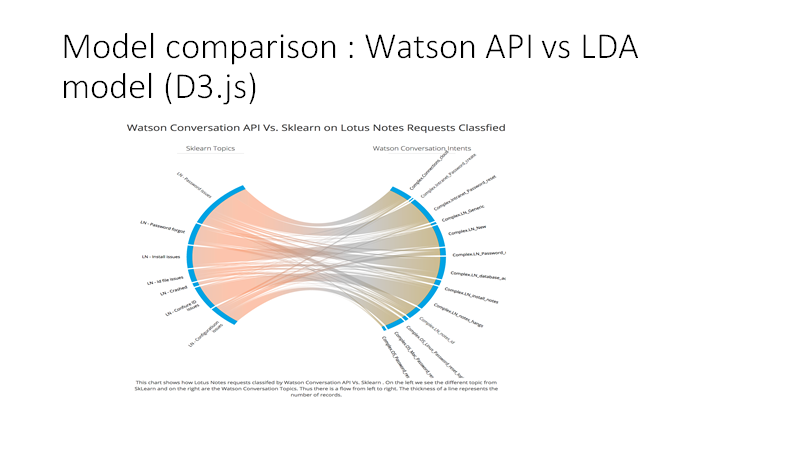

### Predict Cluster assignment - Done

In [17]:
#pd_topic_predicted.hist(by = "topic")
#pd_topic_predicted.hist()

In [25]:
pd_topic_predicted['count'] = 1

In [26]:
ppd_group = pd_topic_predicted.groupby(['topic']).sum()

In [35]:
#ppd_group.sort_values('count')
ppd_group.sort_values('count',ascending=False)

,count
topic,
LN - Config/Install- big cluster,1162
LN - Password reset,371
LN - Configuratiuon issues,243
LN - Setup issues,158
LN - Send/Receive issues,157
LN - Id file issues,128
LN - Unable to open,122
LN - Not working- No info provided,101
LN - Password expired,99


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#budget = pd.read_csv("mn-budget-detail-2014.csv")
#budget = budget.sort('amount',ascending=False)[:10]

In [33]:
from bokeh.plotting import Histogram, output_file, show
from bokeh.sampledata.autompg import autompg as df

ImportError: cannot import name 'Histogram'

In [31]:
ppd_group.sort('count', inplace=True)

hist = Histogram(ppd_group, values='hp', color='cyl',
                 title="HP Distribution by Cylinder Count", legend='top_right')

output_file("histogram_single.html", title="histogram_single.py example")

show(hist)

ModuleNotFoundError: No module named 'bokeh.charts'